In [159]:

import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as geopandas
import numpy as np
from shapely import Point
import seaborn as sns
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from geopy.extra.rate_limiter import RateLimiter
import folium

In [160]:
df= pd.read_csv("./Meteorite Landing - Meteorite-Landings.csv")
df.head()

,Name,ID,NameType,Classification,Mass,Fall,Year,Coordinates
0,Aachen,1,Valid,L5,"Quantity[21, ""Grams""]",Fell,"DateObject[{1880}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{50.775, 6.08333}]"
1,Aarhus,2,Valid,H6,"Quantity[720, ""Grams""]",Fell,"DateObject[{1951}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{56.18333, 10.23333}]"
2,Abee,6,Valid,EH4,"Quantity[107000, ""Grams""]",Fell,"DateObject[{1952}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{54.21667, -113.}]"
3,Acapulco,10,Valid,Acapulcoite,"Quantity[1914, ""Grams""]",Fell,"DateObject[{1976}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{16.88333, -99.9}]"
4,Achiras,370,Valid,L6,"Quantity[780, ""Grams""]",Fell,"DateObject[{1902}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{-33.16667, -64.95}]"


In [161]:
df['year_cleaned'] = df['Year'].str.extract(r'(\d{4})', expand=False)
df['year_cleaned'] = pd.to_numeric(df['year_cleaned'], errors='coerce')
df["year_cleaned"].isna().value_counts()

year_cleaned
False    45422
True       294
Name: count, dtype: int64

In [162]:
mass = df['Mass'].str.extract(r'Quantity\[(\d+\.?\d*), "([a-zA-Z]+)"\]')
mass.columns = ['num', 'unit']
df['num'] = mass['num']

df['Unit'] = mass['unit']

df['num'] = pd.to_numeric(df['num'], errors='coerce')

df["Unit"]=df["Unit"].fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            45716 non-null  object 
 1   ID              45716 non-null  int64  
 2   NameType        45716 non-null  object 
 3   Classification  45716 non-null  object 
 4   Mass            45716 non-null  object 
 5   Fall            45716 non-null  object 
 6   Year            45716 non-null  object 
 7   Coordinates     45716 non-null  object 
 8   year_cleaned    45422 non-null  float64
 9   num             45585 non-null  float64
 10  Unit            45716 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.8+ MB


In [163]:

coords = df['Coordinates'].str.extract(r'GeoPosition\[\{(-?\d+\.?\d*), (-?\d+\.?\d*)\}\]')
coords.columns = ['latitude', 'longitude']
df['latitude'] = coords['latitude']
df['longitude'] = coords['longitude']
print(df["latitude"].isna().count())
df.dropna(subset=['latitude', 'longitude'], inplace=True)
print(df[['Coordinates', 'latitude', 'longitude']].head())
print("\nData types of the new DataFrame:")
df.info()

45716
                         Coordinates   latitude longitude
0     GeoPosition[{50.775, 6.08333}]     50.775   6.08333
1  GeoPosition[{56.18333, 10.23333}]   56.18333  10.23333
2     GeoPosition[{54.21667, -113.}]   54.21667     -113.
3     GeoPosition[{16.88333, -99.9}]   16.88333     -99.9
4   GeoPosition[{-33.16667, -64.95}]  -33.16667    -64.95

Data types of the new DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 32187 entries, 0 to 45715
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            32187 non-null  object 
 1   ID              32187 non-null  int64  
 2   NameType        32187 non-null  object 
 3   Classification  32187 non-null  object 
 4   Mass            32187 non-null  object 
 5   Fall            32187 non-null  object 
 6   Year            32187 non-null  object 
 7   Coordinates     32187 non-null  object 
 8   year_cleaned    32035 non-null  float64
 9   num     

Meteorite data with country name found for each point:
             Name   latitude   longitude                     ADMIN
0          Aachen     50.775     6.08333                   Belgium
1          Aarhus   56.18333    10.23333                   Denmark
2            Abee   54.21667       -113.                    Canada
3        Acapulco   16.88333       -99.9                    Mexico
4         Achiras  -33.16667      -64.95                 Argentina
...           ...        ...         ...                       ...
45711  Zillah 002     29.037     17.0185                     Libya
45712      Zinder   13.78333     8.96667                     Niger
45713        Zlin      49.25    17.66667                   Czechia
45714   Zubkovsky   49.78917     41.5046                    Russia
45715  Zulu Queen   33.98333  -115.68333  United States of America

[32187 rows x 4 columns]


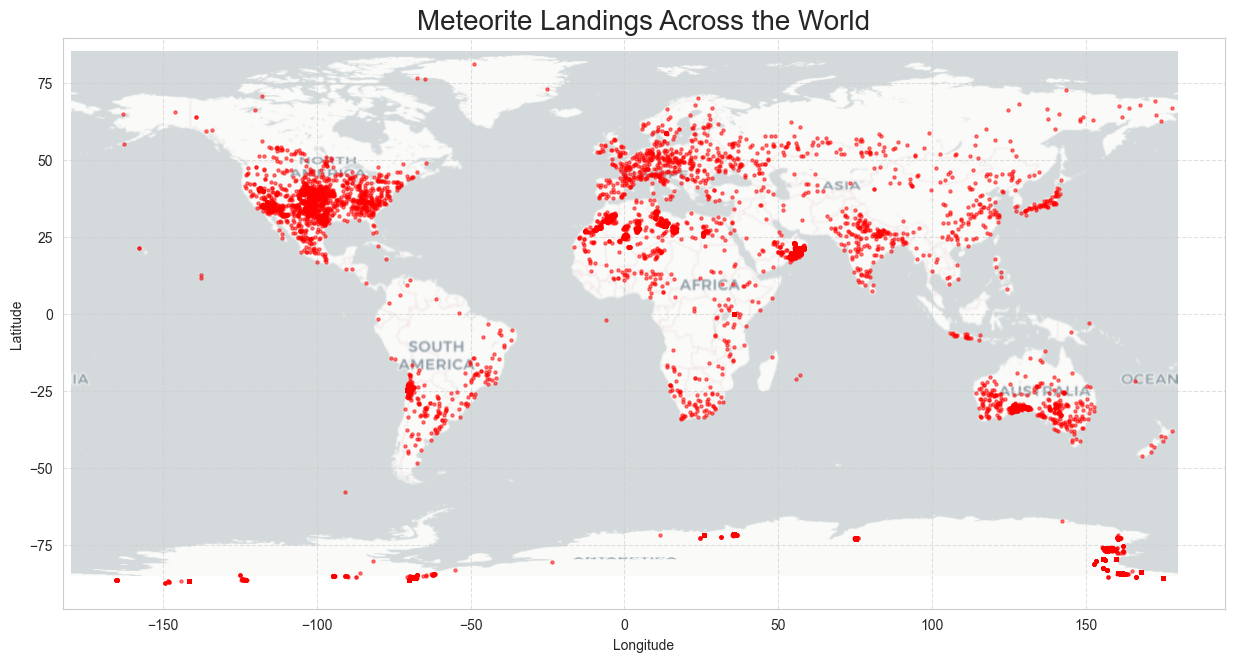

In [164]:

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

gdf = geopandas.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the meteorite landings
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.5)

# Add a basemap
ctx.add_basemap(ax, 
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.Positron,
                attribution=False)

# Add a title and labels
plt.title('Meteorite Landings Across the World', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)
# --- 4. LOAD THE WORLD MAP & PERFORM THE SPATIAL JOIN (MANUAL METHOD) ---

world = geopandas.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = world.set_crs("EPSG:4326")
#  It finds which country each meteorite point is in.
gdf_with_locations = geopandas.sjoin(gdf, world, how="left", predicate='within')



print("Meteorite data with country name found for each point:")
print(gdf_with_locations[['Name', 'latitude', 'longitude','ADMIN']])
df["Location_name"]=gdf_with_locations["ADMIN"]

plt.show()

In [165]:

df_sample = df.sample(n=min(15, len(df)), random_state=42)

# Initialize the geocoder
geolocator = Nominatim(user_agent="meteorite_investigator_app")
# Use RateLimiter to avoid being blocked (1 request per second)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

print("Fetching location data for the sample...")
# Get the location name for each point in the sample
df_sample['location'] = df_sample.apply(
    lambda row: reverse((row['latitude'], row['longitude']), language='en', exactly_one=True),
    axis=1
)
print("Done fetching.")

df["location"]=df_sample["location"]


Fetching location data for the sample...
Done fetching.


In [166]:
df["location"].value_counts()

location
(Thumrait Province, Dhofar Governorate, Oman, (18.4126769, 53.8741508))    2
(Briscoe County, Texas, United States, (34.4795161, -101.1875029))         1
Name: count, dtype: int64

In [167]:
df.head()

,Name,ID,NameType,Classification,Mass,Fall,Year,Coordinates,year_cleaned,num,Unit,latitude,longitude,Location_name,location
0,Aachen,1,Valid,L5,"Quantity[21, ""Grams""]",Fell,"DateObject[{1880}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{50.775, 6.08333}]",1880.0,21.0,Grams,50.775,6.08333,Belgium,NaN
1,Aarhus,2,Valid,H6,"Quantity[720, ""Grams""]",Fell,"DateObject[{1951}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{56.18333, 10.23333}]",1951.0,720.0,Grams,56.18333,10.23333,Denmark,NaN
2,Abee,6,Valid,EH4,"Quantity[107000, ""Grams""]",Fell,"DateObject[{1952}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{54.21667, -113.}]",1952.0,107000.0,Grams,54.21667,-113.,Canada,NaN
3,Acapulco,10,Valid,Acapulcoite,"Quantity[1914, ""Grams""]",Fell,"DateObject[{1976}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{16.88333, -99.9}]",1976.0,1914.0,Grams,16.88333,-99.9,Mexico,NaN
4,Achiras,370,Valid,L6,"Quantity[780, ""Grams""]",Fell,"DateObject[{1902}, ""Year"", ""Gregorian"", -5.]","GeoPosition[{-33.16667, -64.95}]",1902.0,780.0,Grams,-33.16667,-64.95,Argentina,NaN


In [168]:
m = folium.Map(location=[20, 0], zoom_start=2)
folium.TileLayer('CartoDB positron').add_to(m)


marker_cluster = MarkerCluster().add_to(m)

print("Adding meteorite points to the map...")

for idx, row in df.iterrows():
    if pd.notna(row['num']):
        mass_display = f"{row['num']/1000:,.2f} kg"
    else:
        mass_display = "Unknown"

    popup_text = f"""
    <b>Name:</b> {row['Name']}<br>
    <b>Mass:</b> {mass_display}<br>
    <b>Year:</b> {row['year_cleaned']}
    """
    

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='#e34a33',
        fill=True,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(marker_cluster) 

print("Map created successfully!")
m.save("meteorite_map_clustered.html")


Adding meteorite points to the map...
Map created successfully!


df.head()

In [169]:

df["Mass_kg"]=df["num"]/1000
df.loc[df["Unit"]=="Grams","Unit"]="Kg"
df.drop(columns=["Year", "Mass", "Coordinates","num"],  inplace=True)
new_order=["Name","ID","NameType","Classification","Fall","year_cleaned","Mass_kg","Unit","latitude","longitude","Location_name","location"]
df=df[new_order]

df=df.rename(columns={"Location_name":"Country"}
    
)
df.head()

,Name,ID,NameType,Classification,Fall,year_cleaned,Mass_kg,Unit,latitude,longitude,Country,location
0,Aachen,1,Valid,L5,Fell,1880.0,0.021,Kg,50.775,6.08333,Belgium,NaN
1,Aarhus,2,Valid,H6,Fell,1951.0,0.720,Kg,56.18333,10.23333,Denmark,NaN
2,Abee,6,Valid,EH4,Fell,1952.0,107.000,Kg,54.21667,-113.,Canada,NaN
3,Acapulco,10,Valid,Acapulcoite,Fell,1976.0,1.914,Kg,16.88333,-99.9,Mexico,NaN
4,Achiras,370,Valid,L6,Fell,1902.0,0.780,Kg,-33.16667,-64.95,Argentina,NaN


In [170]:
df.sort_values(by="Mass_kg",ascending=False).head(10) #Top 10 Heaviest meteorites

,Name,ID,NameType,Classification,Fall,year_cleaned,Mass_kg,Unit,latitude,longitude,Country,location
16392,Hope,11890,Valid,"Iron, IVB",Found,1920.0,60000.0,Kg,-19.58333,17.91667,Namibia,NaN
5373,Catalina 011,5262,Valid,"Iron, IIIAB",Found,1818.0,58200.0,Kg,76.13333,-64.93333,NaN,NaN
5365,Catalina 003,5247,Valid,"Iron, IAB-MG",Found,1575.0,50000.0,Kg,-27.46667,-60.58333,Argentina,NaN
5370,Catalina 008,5257,Valid,"Iron, IAB-MG",Found,1891.0,30000.0,Kg,35.05,-111.03333,United States of America,NaN
3455,Asuka 8602,2335,Valid,"Iron, IIIE",Found,1898.0,28000.0,Kg,47.,88.,China,NaN
12613,Glorieta Mountain,10912,Valid,"Iron, IVA",Found,1836.0,26000.0,Kg,-25.5,18.,Namibia,NaN
5468,Colorado Springs,5363,Valid,"Iron, IIIAB",Found,1852.0,24300.0,Kg,27.,-105.1,Mexico,NaN
26297,Mundrabilla 005,16852,Valid,"Iron, IAB-ung",Found,1911.0,24000.0,Kg,-30.78333,127.55,Australia,NaN
920,Sinai,23593,Valid,"Iron, IIAB",Fell,1947.0,23000.0,Kg,46.16,134.65333,Russia,NaN
5016,Bates Nunataks A78005,4919,Valid,"Iron, ungrouped",Found,1863.0,22000.0,Kg,26.2,-107.83333,Mexico,NaN


In [171]:
mass_array = df['Mass_kg'].to_numpy()


mean_mass = np.nanmean(mass_array)
median_mass = np.nanmedian(mass_array)
std_mass = np.nanstd(mass_array)
sum_mass = np.nansum(mass_array)
max_mass = np.nanmax(mass_array)

print(f"Mean: {mean_mass:,.2f} kg")
print(f"Median: {median_mass:,.2f} kg")
print(f"Standard Deviation: {std_mass:,.2f} kg")
print(f"Total: {sum_mass:,.2f} kg")
print(f"Max mass: {max_mass:,.2f} kg")


Mean: 18.52 kg
Median: 0.03 kg
Standard Deviation: 685.36 kg
Total: 593,865.48 kg
Max mass: 60,000.00 kg


In [172]:
df["Fall"].value_counts()

Fall
Found    31091
Fell      1096
Name: count, dtype: int64

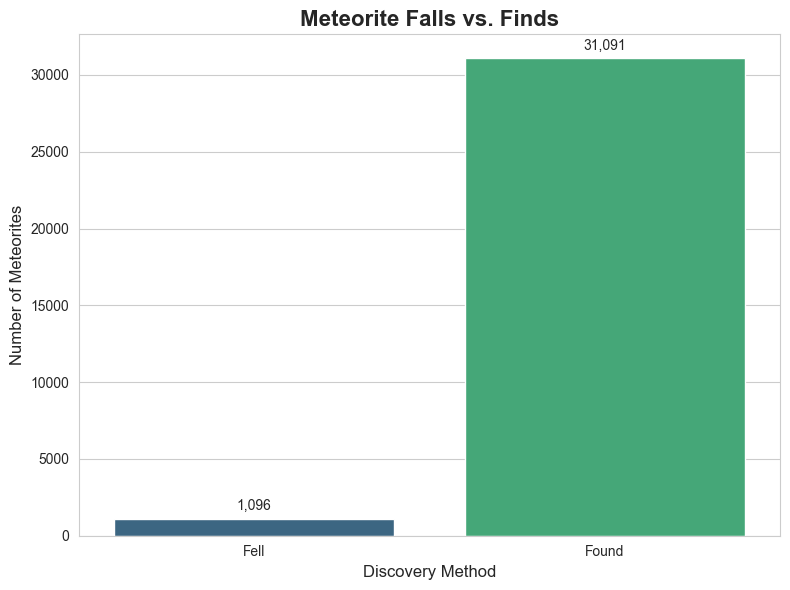

In [176]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.countplot(x='Fall', data=df, palette='viridis', order=['Fell', 'Found'], hue='Fall', legend=False)
ax.set_title('Meteorite Falls vs. Finds', fontsize=16, fontweight='bold')
ax.set_xlabel('Discovery Method', fontsize=12)
ax.set_ylabel('Number of Meteorites', fontsize=12)
 # Add count labels on top of bars
for p in ax.patches:
  ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
  ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.tight_layout()
   
plt.show()

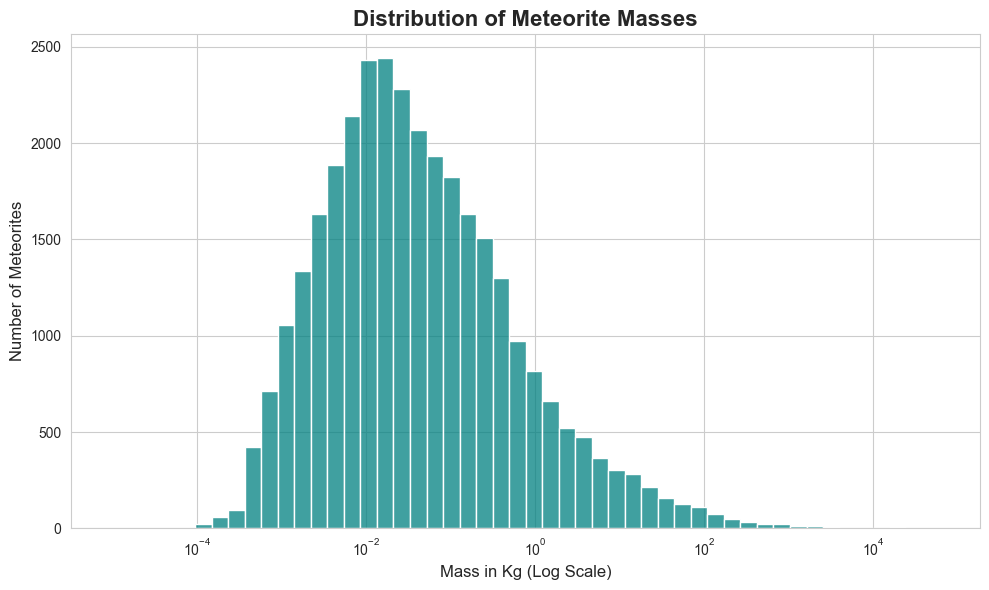

In [174]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.histplot(df['Mass_kg'], bins=50, color='teal', log_scale=True)
ax.set_title('Distribution of Meteorite Masses', fontsize=16, fontweight='bold')
ax.set_xlabel('Mass in Kg (Log Scale)', fontsize=12)
ax.set_ylabel('Number of Meteorites', fontsize=12)
plt.tight_layout()
 
plt.show()

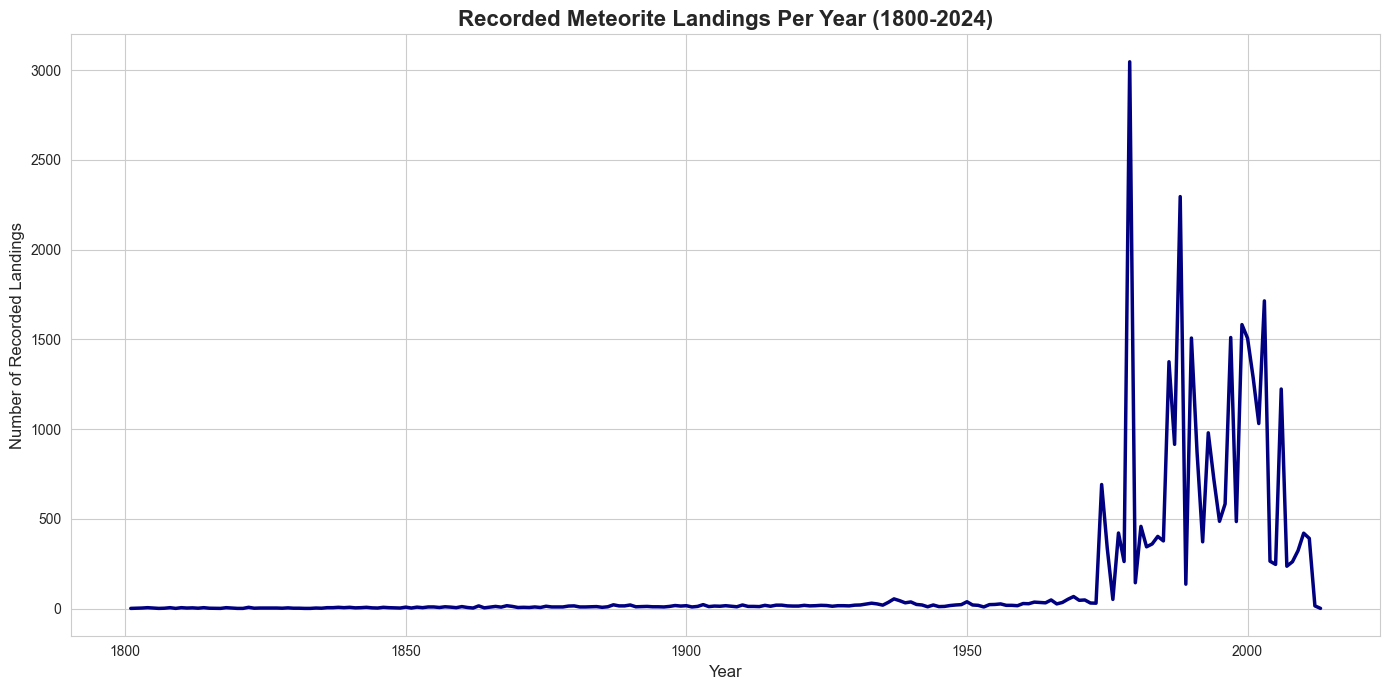

In [175]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
    # Group data by year and count landings
landings_by_year = df['year_cleaned'].value_counts().sort_index()
    # Focus on a more modern time range for better readability
landings_by_year = landings_by_year[(landings_by_year.index >= 1800) & (landings_by_year.index <= 2024)]
ax = sns.lineplot(data=landings_by_year, color='navy', linewidth=2.5)
ax.set_title('Recorded Meteorite Landings Per Year (1800-2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Recorded Landings', fontsize=12)
plt.tight_layout()
   
plt.show()